# Day 7: Week 11 Review - Feature Engineering

## 📚 Week Summary

| Day | Topic | Key Concept |
|-----|-------|-------------|
| 1 | Technical Features | RSI, MACD, BB |
| 2 | Fundamental/Macro | Cross-asset, VIX |
| 3 | Time Features | Seasonality, calendar |
| 4 | Feature Selection | RFE, importance |
| 5 | Transformations | Z-score, log, rank |
| 6 | Target Engineering | Triple barrier, multi-horizon |

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)

# Handle multi-level columns from yfinance
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

print(f"✅ Data: {len(data)} days")

✅ Data: 1254 days


In [2]:
# Comprehensive feature engineering pipeline
def build_all_features(df):
    data = df.copy()
    close = data['Close']
    high = data['High']
    low = data['Low']
    volume = data['Volume']
    
    # TECHNICAL
    # Returns
    data['ret_1d'] = close.pct_change()
    data['ret_5d'] = close.pct_change(5)
    data['ret_20d'] = close.pct_change(20)
    
    # Moving averages
    for w in [5, 10, 20, 50]:
        data[f'sma_{w}_dist'] = (close - close.rolling(w).mean()) / close.rolling(w).mean()
    
    # RSI
    delta = close.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    data['rsi'] = 100 - 100 / (1 + gain / loss)
    
    # MACD
    ema12 = close.ewm(span=12).mean()
    ema26 = close.ewm(span=26).mean()
    data['macd'] = ema12 - ema26
    data['macd_signal'] = data['macd'].ewm(span=9).mean()
    
    # Bollinger
    bb_mid = close.rolling(20).mean()
    bb_std = close.rolling(20).std()
    data['bb_position'] = (close - (bb_mid - 2*bb_std)) / (4*bb_std)
    
    # Volatility
    data['volatility'] = data['ret_1d'].rolling(20).std()
    data['vol_ratio'] = data['volatility'] / data['volatility'].rolling(60).mean()
    
    # Volume
    data['volume_ratio'] = volume / volume.rolling(20).mean()
    
    # TIME FEATURES
    data['dow'] = data.index.dayofweek
    data['month'] = data.index.month
    data['dow_sin'] = np.sin(2 * np.pi * data['dow'] / 5)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    
    # TRANSFORMED FEATURES
    data['ret_zscore'] = (data['ret_1d'] - data['ret_1d'].rolling(60).mean()) / data['ret_1d'].rolling(60).std()
    data['vol_zscore'] = (volume - volume.rolling(60).mean()) / volume.rolling(60).std()
    
    # TARGET
    data['target'] = np.sign(close.shift(-1) - close).map({1: 1, -1: 0, 0: 1})
    
    return data

df = build_all_features(data)
df = df.dropna()

feature_cols = ['ret_1d', 'ret_5d', 'ret_20d', 'sma_5_dist', 'sma_10_dist', 
                'sma_20_dist', 'sma_50_dist', 'rsi', 'macd', 'macd_signal',
                'bb_position', 'volatility', 'vol_ratio', 'volume_ratio',
                'dow_sin', 'month_sin', 'ret_zscore', 'vol_zscore']

print(f"\n📊 Features: {len(feature_cols)}")


📊 Features: 18


In [3]:
# Feature selection
X = df[feature_cols]
y = df['target']

selector = SelectKBest(mutual_info_classif, k=10)
selector.fit(X, y)

selected_features = [f for f, s in zip(feature_cols, selector.get_support()) if s]
print(f"\nSelected features: {selected_features}")


Selected features: ['ret_5d', 'ret_20d', 'sma_5_dist', 'sma_20_dist', 'sma_50_dist', 'macd', 'volume_ratio', 'month_sin', 'ret_zscore', 'vol_zscore']


In [4]:
# Train/test split
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train[selected_features]
y_train = train['target']
X_test = test[selected_features]
y_test = test['target']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Model comparison
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
}

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

best_model = None
best_acc = 0

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train_scaled))
    test_acc = accuracy_score(y_test, model.predict(X_test_scaled))
    print(f"\n{name}:")
    print(f"  Train: {train_acc:.1%}")
    print(f"  Test: {test_acc:.1%}")
    
    if test_acc > best_acc:
        best_acc = test_acc
        best_model = model


MODEL COMPARISON

RandomForest:
  Train: 74.8%
  Test: 51.5%

GradientBoosting:
  Train: 87.0%
  Test: 48.9%


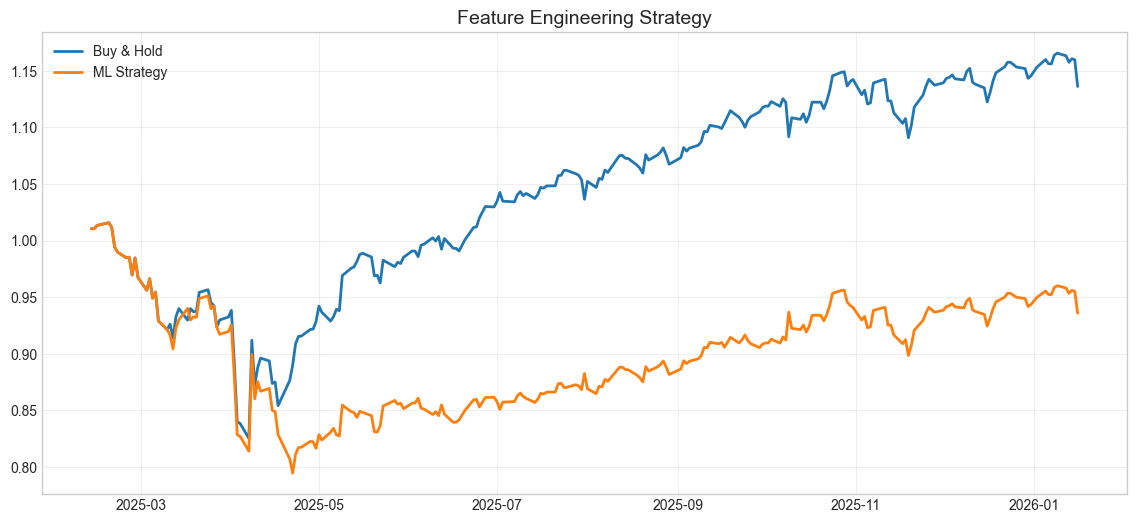

In [6]:
# Strategy with best model
result = test.copy()
result['prediction'] = best_model.predict(X_test_scaled)
result['signal'] = result['prediction'].map({1: 1, 0: -1})
result['next_return'] = result['ret_1d'].shift(-1)
result['strategy_return'] = result['signal'] * result['next_return']

result = result.dropna()
result['strategy_cum'] = (1 + result['strategy_return']).cumprod()
result['buy_hold_cum'] = (1 + result['next_return']).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(result.index, result['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(result.index, result['strategy_cum'], label='ML Strategy', linewidth=2)
plt.title('Feature Engineering Strategy', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Performance metrics
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

bh_total, bh_sharpe, bh_mdd = calc_metrics(result['next_return'], result['buy_hold_cum'])
st_total, st_sharpe, st_mdd = calc_metrics(result['strategy_return'], result['strategy_cum'])

print(f"\n{'Strategy':<15} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 50)
print(f"{'Buy & Hold':<15} {bh_total:>12.2%} {bh_sharpe:>10.2f} {bh_mdd:>10.2%}")
print(f"{'ML Strategy':<15} {st_total:>12.2%} {st_sharpe:>10.2f} {st_mdd:>10.2%}")


STRATEGY PERFORMANCE

Strategy           Total Ret     Sharpe     Max DD
--------------------------------------------------
Buy & Hold            13.62%       0.54    -18.76%
ML Strategy           -6.42%      -0.51    -21.78%


In [8]:
# Today's signal
latest = df[selected_features].iloc[[-1]]
latest_scaled = scaler.transform(latest)
pred = best_model.predict(latest_scaled)[0]
prob = best_model.predict_proba(latest_scaled)[0]

print("\n" + "="*60)
print(f"📊 TODAY'S TRADING SIGNAL FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Price: ${data['Close'].iloc[-1]:.2f}")

print(f"\nKey Features:")
for f in selected_features[:5]:
    print(f"  {f}: {df[f].iloc[-1]:.4f}")

print(f"\n🎯 Signal: {'📈 LONG' if pred == 1 else '📉 SHORT'}")
print(f"   Confidence: {max(prob):.1%}")


📊 TODAY'S TRADING SIGNAL FOR SPY

Date: 2026-01-20
Price: $685.40

Key Features:
  ret_5d: -0.0253
  ret_20d: 0.0046
  sma_5_dist: -0.0167
  sma_20_dist: -0.0157
  sma_50_dist: -0.0034

🎯 Signal: 📈 LONG
   Confidence: 51.9%


---

## 🏢 Interview Questions

### Q1: Most important feature engineering principles?
- Avoid look-ahead bias
- Handle non-stationarity
- Feature selection to prevent overfitting

### Q2: Technical vs fundamental features?
- Technical: Price patterns, momentum, volatility
- Fundamental: Valuations, cross-asset, macro
- Best: Combine both

### Q3: Feature selection methods?
- Filter: Statistical tests (MI, correlation)
- Wrapper: RFE, forward/backward
- Embedded: L1 regularization, tree importance

---
## 📅 Next Week: Advanced Backtesting